<a href="https://colab.research.google.com/github/Farida-EL-Shenawy/AI-ML-projects/blob/main/5G_Network_optimized_Classification_of_dropped_connection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [159]:
#Basic libraries
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Preprocessing & Feature Engineering
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

#Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

#Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
#Model Saving
import joblib

# Warnings
import warnings
warnings.filterwarnings('ignore')

# **Downloading Dataset from Kaggle to Colab**

In [98]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"faridakhaledaly","key":"0ff9c567c66f6538c82d86465cf0b231"}'}

In [99]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [100]:
!pip install -q kaggle

In [101]:
!kaggle datasets download -d vinothkannaece/5g-network-data

Dataset URL: https://www.kaggle.com/datasets/vinothkannaece/5g-network-data
License(s): apache-2.0
  0% 0.00/1.80M [00:00<?, ?B/s]
100% 1.80M/1.80M [00:00<00:00, 395MB/s]


In [102]:
!unzip -q 5g-network-data.zip -d 5g_data

In [103]:
!ls 5g_data

5g_network_data.csv


# **Load Data and Understand Structure**

We start by loading the dataset and inspecting its shape, data types, sample rows, and basic stats to understand its structure.

In [175]:
df = pd.read_csv('5g_data/5g_network_data.csv')

In [161]:
df.head()

,Timestamp,Location,Signal Strength (dBm),Download Speed (Mbps),Upload Speed (Mbps),Latency (ms),Jitter (ms),Network Type,Device Model,Carrier,...,Battery Level (%),Temperature (°C),Connected Duration (min),Handover Count,Data Usage (MB),Video Streaming Quality,VoNR Enabled,Network Congestion Level,Ping to Google (ms),Dropped Connection
0,2025-05-28 06:59:51.089339,San Francisco,-108.6,714.94,60.41,10.0,4.09,5G NSA,iPhone 14,AT&T,...,99,35.5,14,1,97.40,4,False,High,27.9,True
1,2025-05-28 06:49:51.089353,San Francisco,-71.5,686.69,148.70,12.3,1.50,4G,Pixel 7,AT&T,...,67,22.0,51,4,143.23,3,True,Medium,22.2,False
2,2025-05-28 06:39:51.089356,Chennai,-67.5,796.34,136.33,19.9,1.22,5G NSA,iPhone 14,Airtel,...,77,36.1,45,2,179.15,5,False,Low,75.5,False
3,2025-05-28 06:29:51.089360,New York,-73.3,208.56,68.59,12.2,4.94,4G,Pixel 7,T-Mobile,...,25,39.3,48,0,128.87,4,False,High,87.5,False
4,2025-05-28 06:19:51.089363,Kolkata,-93.2,409.85,137.23,6.3,2.94,5G NSA,Galaxy S23,BSNL,...,51,22.7,54,4,156.91,1,True,Medium,32.5,True


In [162]:
print("Shape:", df.shape)

Shape: (50000, 21)


In [163]:
print("\nColumns:", df.columns.tolist())


Columns: ['Timestamp', 'Location', 'Signal Strength (dBm)', 'Download Speed (Mbps)', 'Upload Speed (Mbps)', 'Latency (ms)', 'Jitter (ms)', 'Network Type', 'Device Model', 'Carrier', 'Band', 'Battery Level (%)', 'Temperature (°C)', 'Connected Duration (min)', 'Handover Count', 'Data Usage (MB)', 'Video Streaming Quality', 'VoNR Enabled', 'Network Congestion Level', 'Ping to Google (ms)', 'Dropped Connection']


In [164]:
# Info about datatypes and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Timestamp                 50000 non-null  object 
 1   Location                  50000 non-null  object 
 2   Signal Strength (dBm)     50000 non-null  float64
 3   Download Speed (Mbps)     50000 non-null  float64
 4   Upload Speed (Mbps)       50000 non-null  float64
 5   Latency (ms)              50000 non-null  float64
 6   Jitter (ms)               50000 non-null  float64
 7   Network Type              50000 non-null  object 
 8   Device Model              50000 non-null  object 
 9   Carrier                   50000 non-null  object 
 10  Band                      50000 non-null  object 
 11  Battery Level (%)         50000 non-null  int64  
 12  Temperature (°C)          50000 non-null  float64
 13  Connected Duration (min)  50000 non-null  int64  
 14  Handov

In [165]:
# Basic statistics
df.describe(include='all')

,Timestamp,Location,Signal Strength (dBm),Download Speed (Mbps),Upload Speed (Mbps),Latency (ms),Jitter (ms),Network Type,Device Model,Carrier,...,Battery Level (%),Temperature (°C),Connected Duration (min),Handover Count,Data Usage (MB),Video Streaming Quality,VoNR Enabled,Network Congestion Level,Ping to Google (ms),Dropped Connection
count,50000,50000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000,50000,50000,...,50000.00000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000,50000,50000.000000,50000
unique,50000,8,NaN,NaN,NaN,NaN,NaN,3,5,7,...,NaN,NaN,NaN,NaN,NaN,NaN,2,3,NaN,2
top,2024-06-15 04:29:51.224656,Berlin,NaN,NaN,NaN,NaN,NaN,5G NSA,Nord 4,AT&T,...,NaN,NaN,NaN,NaN,NaN,NaN,True,Low,NaN,True
freq,1,6346,NaN,NaN,NaN,NaN,NaN,16793,10076,8382,...,NaN,NaN,NaN,NaN,NaN,NaN,25055,16791,NaN,25031
mean,NaN,NaN,-84.837274,551.181074,84.801756,10.497244,2.560705,NaN,NaN,NaN,...,54.57914,32.450312,29.855440,2.00420,254.381145,2.999980,NaN,NaN,54.947062,NaN
std,NaN,NaN,14.477643,260.434443,37.590811,5.505071,1.416085,NaN,NaN,NaN,...,26.03389,7.216729,16.995328,1.41771,140.989033,1.415945,NaN,NaN,25.983514,NaN
min,NaN,NaN,-110.000000,100.040000,20.000000,1.000000,0.100000,NaN,NaN,NaN,...,10.00000,20.000000,1.000000,0.00000,10.000000,1.000000,NaN,NaN,10.000000,NaN
25%,NaN,NaN,-97.400000,324.650000,52.230000,5.700000,1.330000,NaN,NaN,NaN,...,32.00000,26.200000,15.000000,1.00000,133.237500,2.000000,NaN,NaN,32.400000,NaN
50%,NaN,NaN,-84.800000,552.130000,84.710000,10.500000,2.570000,NaN,NaN,NaN,...,55.00000,32.400000,30.000000,2.00000,252.975000,3.000000,NaN,NaN,55.000000,NaN
75%,NaN,NaN,-72.200000,775.875000,117.320000,15.300000,3.780000,NaN,NaN,NaN,...,77.00000,38.700000,45.000000,3.00000,376.425000,4.000000,NaN,NaN,77.400000,NaN


In [166]:
import plotly.express as px

# Count the values
counts = df['Dropped Connection'].value_counts().reset_index()
counts.columns = ['Dropped Connection', 'Count']

# Map your custom colors
color_map = {1: 'blue', 0: 'pink'}  # Assuming true=1, false=0 in label encoding

# Plot
fig = px.bar(
    counts,
    x='Dropped Connection',
    y='Count',
    color='Dropped Connection',
    color_discrete_map=color_map,
    text='Count',
    title='Distribution of Dropped Connection'
)

fig.update_layout(
    xaxis_title='Dropped Connection',
    yaxis_title='Count',
    plot_bgcolor='white'
)

fig.show()

# **Are there Any Missing Values ?**

We want to see where missing values exist to plan our imputation.

In [167]:
# Count missing values
df.isnull().sum()

,0
Timestamp,0
Location,0
Signal Strength (dBm),0
Download Speed (Mbps),0
Upload Speed (Mbps),0
Latency (ms),0
Jitter (ms),0
Network Type,0
Device Model,0
Carrier,0


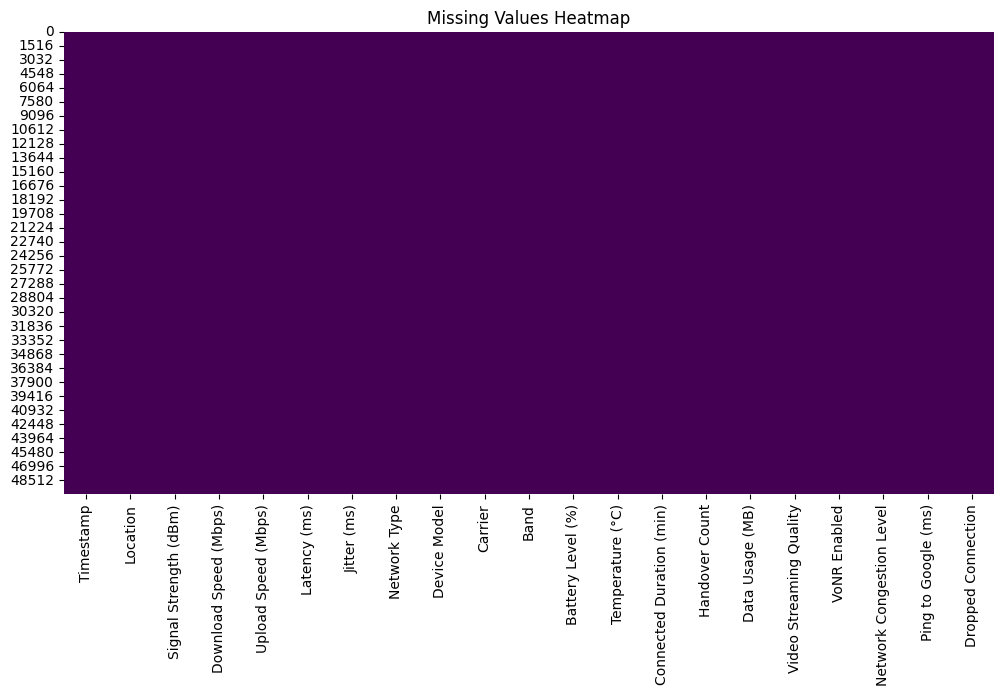

In [168]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# **Timestamp Handling**

In [176]:
# Convert timestamp to datetime if it's string
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract time-based features
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month

# Optional: Is weekend
df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)

# Drop original Timestamp
df = df.drop(columns=['Timestamp'])

df.head(100)

,Location,Signal Strength (dBm),Download Speed (Mbps),Upload Speed (Mbps),Latency (ms),Jitter (ms),Network Type,Device Model,Carrier,Band,...,Data Usage (MB),Video Streaming Quality,VoNR Enabled,Network Congestion Level,Ping to Google (ms),Dropped Connection,Hour,DayOfWeek,Month,IsWeekend
0,San Francisco,-108.6,714.94,60.41,10.0,4.09,5G NSA,iPhone 14,AT&T,n78,...,97.40,4,False,High,27.9,True,6,2,5,0
1,San Francisco,-71.5,686.69,148.70,12.3,1.50,4G,Pixel 7,AT&T,n260,...,143.23,3,True,Medium,22.2,False,6,2,5,0
2,Chennai,-67.5,796.34,136.33,19.9,1.22,5G NSA,iPhone 14,Airtel,n78,...,179.15,5,False,Low,75.5,False,6,2,5,0
3,New York,-73.3,208.56,68.59,12.2,4.94,4G,Pixel 7,T-Mobile,n41,...,128.87,4,False,High,87.5,False,6,2,5,0
4,Kolkata,-93.2,409.85,137.23,6.3,2.94,5G NSA,Galaxy S23,BSNL,n28,...,156.91,1,True,Medium,32.5,True,6,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Kolkata,-74.7,310.60,128.40,15.5,0.86,4G,Nord 4,Airtel,n258,...,343.92,5,True,High,13.5,True,15,1,5,0
96,San Francisco,-93.9,228.91,35.87,16.0,4.11,5G SA,Nord 4,T-Mobile,n41,...,325.37,1,False,Low,90.3,True,14,1,5,0
97,San Francisco,-105.9,362.61,149.34,11.2,3.18,5G NSA,iPhone 14,AT&T,n78,...,28.49,1,True,Medium,71.8,False,14,1,5,0
98,New York,-85.5,476.05,58.42,5.8,4.15,5G NSA,iPhone 14,Verizon,n78,...,243.05,5,True,Medium,94.6,True,14,1,5,0


In [177]:
df = df.drop(columns=['IsWeekend'])

In [178]:
# Check result
print("Columns after dropping:")
print(df.columns.tolist())

Columns after dropping:
['Location', 'Signal Strength (dBm)', 'Download Speed (Mbps)', 'Upload Speed (Mbps)', 'Latency (ms)', 'Jitter (ms)', 'Network Type', 'Device Model', 'Carrier', 'Band', 'Battery Level (%)', 'Temperature (°C)', 'Connected Duration (min)', 'Handover Count', 'Data Usage (MB)', 'Video Streaming Quality', 'VoNR Enabled', 'Network Congestion Level', 'Ping to Google (ms)', 'Dropped Connection', 'Hour', 'DayOfWeek', 'Month']


In [179]:
# Quick preview
df.head()

,Location,Signal Strength (dBm),Download Speed (Mbps),Upload Speed (Mbps),Latency (ms),Jitter (ms),Network Type,Device Model,Carrier,Band,...,Handover Count,Data Usage (MB),Video Streaming Quality,VoNR Enabled,Network Congestion Level,Ping to Google (ms),Dropped Connection,Hour,DayOfWeek,Month
0,San Francisco,-108.6,714.94,60.41,10.0,4.09,5G NSA,iPhone 14,AT&T,n78,...,1,97.40,4,False,High,27.9,True,6,2,5
1,San Francisco,-71.5,686.69,148.70,12.3,1.50,4G,Pixel 7,AT&T,n260,...,4,143.23,3,True,Medium,22.2,False,6,2,5
2,Chennai,-67.5,796.34,136.33,19.9,1.22,5G NSA,iPhone 14,Airtel,n78,...,2,179.15,5,False,Low,75.5,False,6,2,5
3,New York,-73.3,208.56,68.59,12.2,4.94,4G,Pixel 7,T-Mobile,n41,...,0,128.87,4,False,High,87.5,False,6,2,5
4,Kolkata,-93.2,409.85,137.23,6.3,2.94,5G NSA,Galaxy S23,BSNL,n28,...,4,156.91,1,True,Medium,32.5,True,6,2,5


In [180]:
df['Latency_Jitter'] = df['Latency (ms)'] * df['Jitter (ms)']
df['Download_Upload'] = df['Download Speed (Mbps)'] * df['Upload Speed (Mbps)']

In [181]:
df.head()

,Location,Signal Strength (dBm),Download Speed (Mbps),Upload Speed (Mbps),Latency (ms),Jitter (ms),Network Type,Device Model,Carrier,Band,...,Video Streaming Quality,VoNR Enabled,Network Congestion Level,Ping to Google (ms),Dropped Connection,Hour,DayOfWeek,Month,Latency_Jitter,Download_Upload
0,San Francisco,-108.6,714.94,60.41,10.0,4.09,5G NSA,iPhone 14,AT&T,n78,...,4,False,High,27.9,True,6,2,5,40.900,43189.5254
1,San Francisco,-71.5,686.69,148.70,12.3,1.50,4G,Pixel 7,AT&T,n260,...,3,True,Medium,22.2,False,6,2,5,18.450,102110.8030
2,Chennai,-67.5,796.34,136.33,19.9,1.22,5G NSA,iPhone 14,Airtel,n78,...,5,False,Low,75.5,False,6,2,5,24.278,108565.0322
3,New York,-73.3,208.56,68.59,12.2,4.94,4G,Pixel 7,T-Mobile,n41,...,4,False,High,87.5,False,6,2,5,60.268,14305.1304
4,Kolkata,-93.2,409.85,137.23,6.3,2.94,5G NSA,Galaxy S23,BSNL,n28,...,1,True,Medium,32.5,True,6,2,5,18.522,56243.7155


In [182]:
# Signal Strength bins
df['Signal_Strength_Bin'] = pd.cut(df['Signal Strength (dBm)'], bins=5, labels=False)

# Temperature bins
df['Temperature_Bin'] = pd.cut(df['Temperature (°C)'], bins=5, labels=False)

# **Are there any Outliers ?**

Using IQR (Interquartile Range):

Q1 = 25th percentile

Q3 = 75th percentile

IQR = Q3 - Q1

Outliers = values outside [Q1 - 1.5×IQR, Q3 + 1.5×IQR]

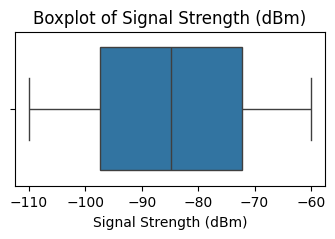

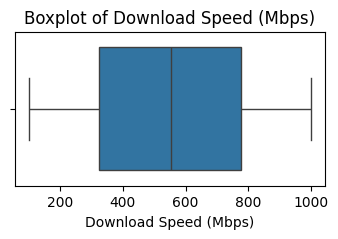

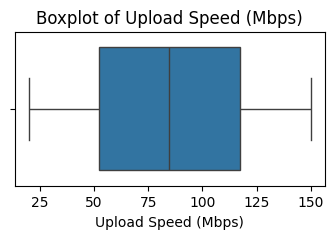

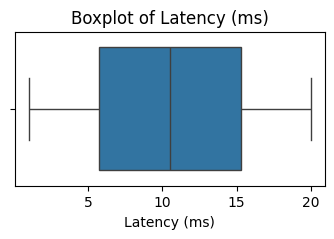

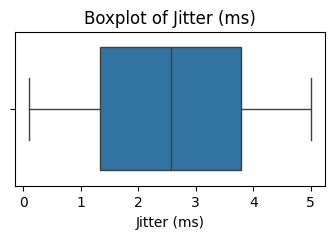

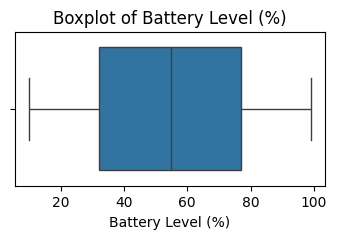

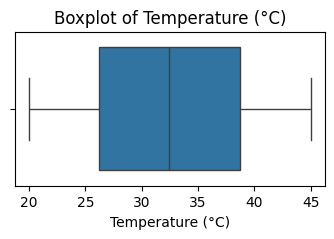

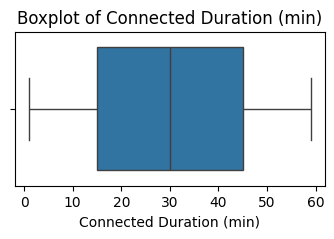

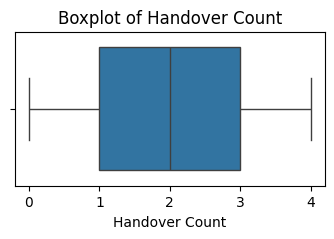

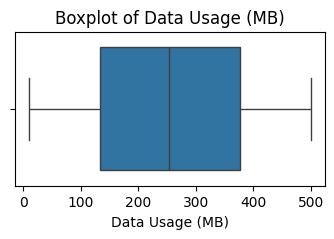

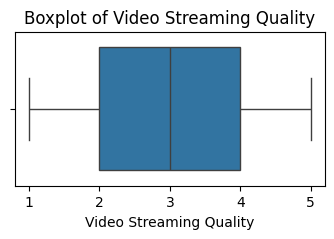

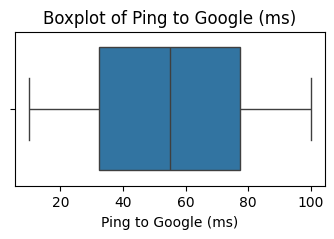

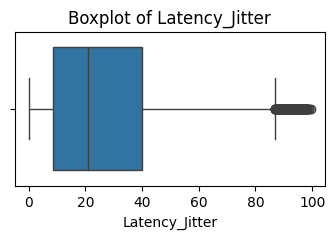

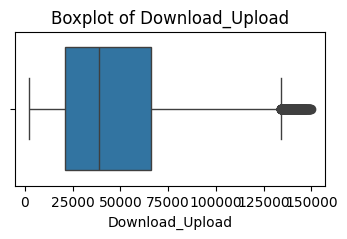

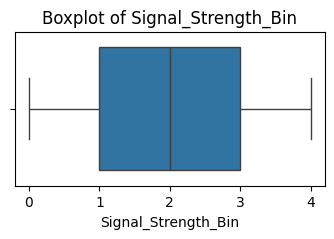

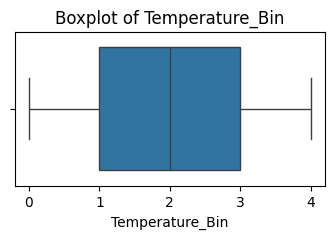

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Boxplots to see outliers
for col in numeric_cols:
    plt.figure(figsize=(4, 2))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [187]:
# Function to detect outliers in numeric columns
def find_outlier_indices(df, cols):
    outlier_indices = set()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices.update(outliers)
    return list(outlier_indices)

outlier_rows = find_outlier_indices(df, numeric_cols)
print(f'Number of rows with outliers: {len(outlier_rows)}')

Number of rows with outliers: 502


In [185]:
for col in ['Latency_Jitter', 'Download_Upload']:
    upper_limit = df[col].quantile(0.70)
    df[col] = np.clip(df[col], a_min=None, a_max=upper_limit)
    print(f"{col} clipped at 99th percentile: {upper_limit:.2f}")

Latency_Jitter clipped at 99th percentile: 86.98
Download_Upload clipped at 99th percentile: 131150.04


In [186]:
# Function to detect outliers in numeric columns
def find_outlier_indices(df, cols):
    outlier_indices = set()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices.update(outliers)
    return list(outlier_indices)

outlier_rows = find_outlier_indices(df, numeric_cols)
print(f'Number of rows with outliers: {len(outlier_rows)}')

Number of rows with outliers: 502


In [188]:
# Signal Strength bins
df['Signal_Strength_Bin'] = pd.cut(df['Signal Strength (dBm)'], bins=5, labels=False)

# Temperature bins
df['Temperature_Bin'] = pd.cut(df['Temperature (°C)'], bins=5, labels=False)

In [189]:
# Frequency encoding for Device Model
device_freq = df['Device Model'].value_counts(normalize=True)
df['Device_Model_Encoded'] = df['Device Model'].map(device_freq)
df.drop(columns=['Device Model'], inplace=True)

# One-hot encode suitable columns
onehot_cols = ['Location', 'Network Type', 'Carrier', 'Network Congestion Level', 'Band']
df = pd.get_dummies(df, columns=onehot_cols, drop_first=True)

print("✅ Encoding complete. Columns now:", df.columns.tolist())

✅ Encoding complete. Columns now: ['Signal Strength (dBm)', 'Download Speed (Mbps)', 'Upload Speed (Mbps)', 'Latency (ms)', 'Jitter (ms)', 'Battery Level (%)', 'Temperature (°C)', 'Connected Duration (min)', 'Handover Count', 'Data Usage (MB)', 'Video Streaming Quality', 'VoNR Enabled', 'Ping to Google (ms)', 'Dropped Connection', 'Hour', 'DayOfWeek', 'Month', 'Latency_Jitter', 'Download_Upload', 'Signal_Strength_Bin', 'Temperature_Bin', 'Device_Model_Encoded', 'Location_Chennai', 'Location_Delhi', 'Location_Kolkata', 'Location_Mumbai', 'Location_New York', 'Location_San Francisco', 'Location_Tokyo', 'Network Type_5G NSA', 'Network Type_5G SA', 'Carrier_Airtel', 'Carrier_BSNL', 'Carrier_Jio', 'Carrier_T-Mobile', 'Carrier_Verizon', 'Carrier_Vi', 'Network Congestion Level_Low', 'Network Congestion Level_Medium', 'Band_n260', 'Band_n28', 'Band_n41', 'Band_n78']


In [190]:
df['Dropped Connection'] = df['Dropped Connection'].astype(int)

In [191]:
from sklearn.preprocessing import StandardScaler

# Identify continuous numeric features
continuous_cols = [col for col in df.columns if df[col].dtype in ['int64','float64'] and col != 'Dropped Connection']
print("Continuous columns to scale:", continuous_cols)

scaler = StandardScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

Continuous columns to scale: ['Signal Strength (dBm)', 'Download Speed (Mbps)', 'Upload Speed (Mbps)', 'Latency (ms)', 'Jitter (ms)', 'Battery Level (%)', 'Temperature (°C)', 'Connected Duration (min)', 'Handover Count', 'Data Usage (MB)', 'Video Streaming Quality', 'Ping to Google (ms)', 'Latency_Jitter', 'Download_Upload', 'Signal_Strength_Bin', 'Temperature_Bin', 'Device_Model_Encoded']


In [192]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Dropped Connection'])
y = df['Dropped Connection']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [193]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Define models
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=300, max_depth=8, learning_rate=0.05, eval_metric='logloss', use_label_encoder=False, random_state=42)
}

# Train and evaluate
for name, model in models.items():
    print(f"\n⭐ Training {name}")
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(f"{name} Test Accuracy: {acc:.4f}")

    # Cross-validation F1
    scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    print(f"{name} Cross-validated F1-score: {scores.mean():.4f}")


⭐ Training RandomForest
RandomForest Test Accuracy: 0.5037
RandomForest Cross-validated F1-score: 0.5372

⭐ Training XGBoost
XGBoost Test Accuracy: 0.5005
XGBoost Cross-validated F1-score: 0.5136


# **Encoding Categorical Variables**

ML models need numbers → we’ll use Label Encoding for simplicity.


In [138]:
print(df.dtypes)

Location                     object
Signal Strength (dBm)       float64
Download Speed (Mbps)       float64
Upload Speed (Mbps)         float64
Latency (ms)                float64
Jitter (ms)                 float64
Network Type                 object
Device Model                 object
Carrier                      object
Band                         object
Battery Level (%)             int64
Temperature (°C)            float64
Connected Duration (min)      int64
Handover Count                int64
Data Usage (MB)             float64
VoNR Enabled                   bool
Network Congestion Level     object
Ping to Google (ms)         float64
Dropped Connection             bool
dtype: object


In [139]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", categorical_cols)

Categorical columns: ['Location', 'Network Type', 'Device Model', 'Carrier', 'Band', 'Network Congestion Level']


### **To prepare our data for modeling, we encoded categorical features appropriately:**

***OneHotEncoding*** : for nominal variables with low cardinality (Location, Network Type, Carrier, Network Congestion Level).

***Frequency Encoding*** : for high-cardinality Device Model, replacing each model with its relative frequency in the dataset.

***Direct binary mapping*** : for Boolean variables (VoNR Enabled, Dropped Connection).

In [140]:
#Map Booleans
df['VoNR Enabled'] = df['VoNR Enabled'].astype(int)
df['Dropped Connection'] = df['Dropped Connection'].astype(int)

In [141]:
#Frequency Encoding for Device Model
device_model_freq = df['Device Model'].value_counts(normalize=True)
df['Device Model Encoded'] = df['Device Model'].map(device_model_freq)
df.drop(columns=['Device Model'], inplace=True)

In [142]:
#OneHotEncoding for Nominal Categoricals
one_hot_cols = ['Location', 'Network Type', 'Carrier', 'Network Congestion Level']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

In [143]:
# OneHotEncode the Band column
df = pd.get_dummies(df, columns=['Band'], drop_first=True)

# Check the new columns
print("Columns after encoding Band:")
print(df.columns.tolist())

# Quick preview
df.head()

Columns after encoding Band:
['Signal Strength (dBm)', 'Download Speed (Mbps)', 'Upload Speed (Mbps)', 'Latency (ms)', 'Jitter (ms)', 'Battery Level (%)', 'Temperature (°C)', 'Connected Duration (min)', 'Handover Count', 'Data Usage (MB)', 'VoNR Enabled', 'Ping to Google (ms)', 'Dropped Connection', 'Device Model Encoded', 'Location_Chennai', 'Location_Delhi', 'Location_Kolkata', 'Location_Mumbai', 'Location_New York', 'Location_San Francisco', 'Location_Tokyo', 'Network Type_5G NSA', 'Network Type_5G SA', 'Carrier_Airtel', 'Carrier_BSNL', 'Carrier_Jio', 'Carrier_T-Mobile', 'Carrier_Verizon', 'Carrier_Vi', 'Network Congestion Level_Low', 'Network Congestion Level_Medium', 'Band_n260', 'Band_n28', 'Band_n41', 'Band_n78']


,Signal Strength (dBm),Download Speed (Mbps),Upload Speed (Mbps),Latency (ms),Jitter (ms),Battery Level (%),Temperature (°C),Connected Duration (min),Handover Count,Data Usage (MB),...,Carrier_Jio,Carrier_T-Mobile,Carrier_Verizon,Carrier_Vi,Network Congestion Level_Low,Network Congestion Level_Medium,Band_n260,Band_n28,Band_n41,Band_n78
0,-108.6,714.94,60.41,10.0,4.09,99,35.5,14,1,97.40,...,False,False,False,False,False,False,False,False,False,True
1,-71.5,686.69,148.70,12.3,1.50,67,22.0,51,4,143.23,...,False,False,False,False,False,True,True,False,False,False
2,-67.5,796.34,136.33,19.9,1.22,77,36.1,45,2,179.15,...,False,False,False,False,True,False,False,False,False,True
3,-73.3,208.56,68.59,12.2,4.94,25,39.3,48,0,128.87,...,False,True,False,False,False,False,False,False,True,False
4,-93.2,409.85,137.23,6.3,2.94,51,22.7,54,4,156.91,...,False,False,False,False,False,True,False,True,False,False


In [144]:
print("Encoded dataframe columns:")
print(df.columns.tolist())

Encoded dataframe columns:
['Signal Strength (dBm)', 'Download Speed (Mbps)', 'Upload Speed (Mbps)', 'Latency (ms)', 'Jitter (ms)', 'Battery Level (%)', 'Temperature (°C)', 'Connected Duration (min)', 'Handover Count', 'Data Usage (MB)', 'VoNR Enabled', 'Ping to Google (ms)', 'Dropped Connection', 'Device Model Encoded', 'Location_Chennai', 'Location_Delhi', 'Location_Kolkata', 'Location_Mumbai', 'Location_New York', 'Location_San Francisco', 'Location_Tokyo', 'Network Type_5G NSA', 'Network Type_5G SA', 'Carrier_Airtel', 'Carrier_BSNL', 'Carrier_Jio', 'Carrier_T-Mobile', 'Carrier_Verizon', 'Carrier_Vi', 'Network Congestion Level_Low', 'Network Congestion Level_Medium', 'Band_n260', 'Band_n28', 'Band_n41', 'Band_n78']


In [145]:
# Quick preview
df.head(10)

,Signal Strength (dBm),Download Speed (Mbps),Upload Speed (Mbps),Latency (ms),Jitter (ms),Battery Level (%),Temperature (°C),Connected Duration (min),Handover Count,Data Usage (MB),...,Carrier_Jio,Carrier_T-Mobile,Carrier_Verizon,Carrier_Vi,Network Congestion Level_Low,Network Congestion Level_Medium,Band_n260,Band_n28,Band_n41,Band_n78
0,-108.6,714.94,60.41,10.0,4.09,99,35.5,14,1,97.40,...,False,False,False,False,False,False,False,False,False,True
1,-71.5,686.69,148.70,12.3,1.50,67,22.0,51,4,143.23,...,False,False,False,False,False,True,True,False,False,False
2,-67.5,796.34,136.33,19.9,1.22,77,36.1,45,2,179.15,...,False,False,False,False,True,False,False,False,False,True
3,-73.3,208.56,68.59,12.2,4.94,25,39.3,48,0,128.87,...,False,True,False,False,False,False,False,False,True,False
4,-93.2,409.85,137.23,6.3,2.94,51,22.7,54,4,156.91,...,False,False,False,False,False,True,False,True,False,False
5,-101.2,727.46,115.13,15.4,2.73,24,34.0,5,3,35.72,...,False,False,False,True,True,False,False,False,False,True
6,-89.4,623.27,79.46,2.8,3.69,17,31.4,59,2,96.21,...,False,False,False,True,False,False,False,False,False,False
7,-65.9,828.31,23.78,8.7,0.27,18,35.6,32,2,338.17,...,False,False,False,False,False,False,False,False,True,False
8,-90.7,630.53,92.39,15.9,0.56,71,37.7,45,4,313.44,...,False,False,False,False,False,True,True,False,False,False
9,-108.4,311.66,77.99,3.7,3.67,20,35.9,34,2,27.32,...,False,False,False,False,True,False,False,False,False,True


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Signal Strength (dBm)            50000 non-null  float64
 1   Download Speed (Mbps)            50000 non-null  float64
 2   Upload Speed (Mbps)              50000 non-null  float64
 3   Latency (ms)                     50000 non-null  float64
 4   Jitter (ms)                      50000 non-null  float64
 5   Battery Level (%)                50000 non-null  int64  
 6   Temperature (°C)                 50000 non-null  float64
 7   Connected Duration (min)         50000 non-null  int64  
 8   Handover Count                   50000 non-null  int64  
 9   Data Usage (MB)                  50000 non-null  float64
 10  VoNR Enabled                     50000 non-null  int64  
 11  Ping to Google (ms)              50000 non-null  float64
 12  Dropped Connection

In [147]:
# ✅ 1️⃣ Find all boolean columns
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
print("All boolean columns:", bool_cols)

# ✅ 2️⃣ Exclude 'Dropped Connection' from the list
bool_cols_to_drop = [col for col in bool_cols if col != 'Dropped Connection']
print("Boolean columns to drop:", bool_cols_to_drop)

# ✅ 3️⃣ Drop them
df = df.drop(columns=bool_cols_to_drop)

# ✅ 4️⃣ Check result
print("✅ New dataframe columns:")
print(df.columns.tolist())

# Optional preview
df.head()

All boolean columns: ['Location_Chennai', 'Location_Delhi', 'Location_Kolkata', 'Location_Mumbai', 'Location_New York', 'Location_San Francisco', 'Location_Tokyo', 'Network Type_5G NSA', 'Network Type_5G SA', 'Carrier_Airtel', 'Carrier_BSNL', 'Carrier_Jio', 'Carrier_T-Mobile', 'Carrier_Verizon', 'Carrier_Vi', 'Network Congestion Level_Low', 'Network Congestion Level_Medium', 'Band_n260', 'Band_n28', 'Band_n41', 'Band_n78']
Boolean columns to drop: ['Location_Chennai', 'Location_Delhi', 'Location_Kolkata', 'Location_Mumbai', 'Location_New York', 'Location_San Francisco', 'Location_Tokyo', 'Network Type_5G NSA', 'Network Type_5G SA', 'Carrier_Airtel', 'Carrier_BSNL', 'Carrier_Jio', 'Carrier_T-Mobile', 'Carrier_Verizon', 'Carrier_Vi', 'Network Congestion Level_Low', 'Network Congestion Level_Medium', 'Band_n260', 'Band_n28', 'Band_n41', 'Band_n78']
✅ New dataframe columns:
['Signal Strength (dBm)', 'Download Speed (Mbps)', 'Upload Speed (Mbps)', 'Latency (ms)', 'Jitter (ms)', 'Battery Lev

,Signal Strength (dBm),Download Speed (Mbps),Upload Speed (Mbps),Latency (ms),Jitter (ms),Battery Level (%),Temperature (°C),Connected Duration (min),Handover Count,Data Usage (MB),VoNR Enabled,Ping to Google (ms),Dropped Connection,Device Model Encoded
0,-108.6,714.94,60.41,10.0,4.09,99,35.5,14,1,97.40,0,27.9,1,0.19952
1,-71.5,686.69,148.70,12.3,1.50,67,22.0,51,4,143.23,1,22.2,0,0.19946
2,-67.5,796.34,136.33,19.9,1.22,77,36.1,45,2,179.15,0,75.5,0,0.19952
3,-73.3,208.56,68.59,12.2,4.94,25,39.3,48,0,128.87,0,87.5,0,0.19946
4,-93.2,409.85,137.23,6.3,2.94,51,22.7,54,4,156.91,1,32.5,1,0.19848


# **Split features and target**

In [148]:
X = df.drop(columns=['Dropped Connection'])
y = df['Dropped Connection']

# **Perform train-test split**

In [154]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("✅ Split complete!")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train distribution:\n{y_train.value_counts(normalize=True)}")

✅ Split complete!
X_train shape: (40000, 13)
X_test shape: (10000, 13)
y_train distribution:
Dropped Connection
1    0.500625
0    0.499375
Name: proportion, dtype: float64


# **Lets Start Scaling**

## **Why StandardScaler?**
We chose StandardScaler to standardize our continuous features to mean=0 and standard deviation=1. This approach preserves the underlying distributions while ensuring comparable scales across features. Unlike MinMaxScaler, which compresses data into [0, 1] and can distort relationships, StandardScaler maintains negative values and is well-suited for models that assume centered, standardized inputs.

In [155]:
from sklearn.preprocessing import StandardScaler

# ✅ 1️⃣ Identify continuous columns (exclude one-hot/binary features)
continuous_cols = [col for col in X_train.columns if X_train[col].dtype != 'bool']
print("Continuous columns to scale:", continuous_cols)

# ✅ 2️⃣ Initialize the scaler
scaler = StandardScaler()

# ✅ 3️⃣ Fit on train and transform
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])

# ✅ 4️⃣ Transform test set using same scaler
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

print("✅ StandardScaler applied successfully!")


Continuous columns to scale: ['Signal Strength (dBm)', 'Download Speed (Mbps)', 'Upload Speed (Mbps)', 'Latency (ms)', 'Jitter (ms)', 'Battery Level (%)', 'Temperature (°C)', 'Connected Duration (min)', 'Handover Count', 'Data Usage (MB)', 'VoNR Enabled', 'Ping to Google (ms)', 'Device Model Encoded']
✅ StandardScaler applied successfully!


# **Lets Choose our best model**

In [156]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

In [157]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}


Training Logistic Regression...
Logistic Regression Accuracy: 0.4989
Logistic Regression F1-score: 0.5126


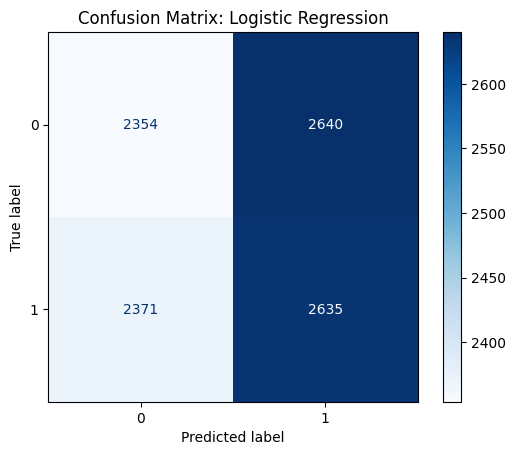


Training Random Forest...
Random Forest Accuracy: 0.4986
Random Forest F1-score: 0.4849


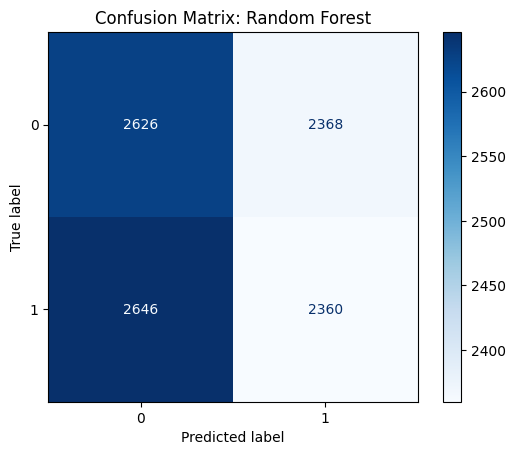


Training XGBoost...
XGBoost Accuracy: 0.4967
XGBoost F1-score: 0.5000


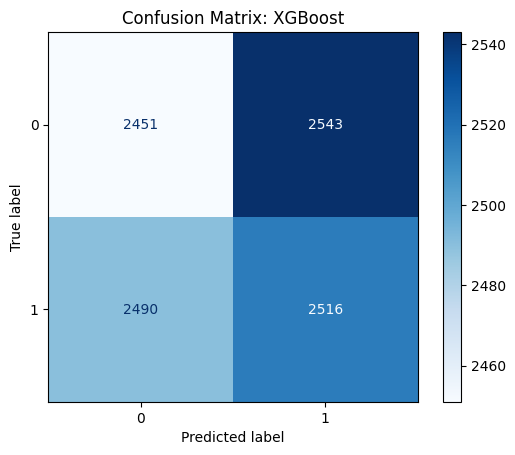


Training KNN...
KNN Accuracy: 0.5016
KNN F1-score: 0.5067


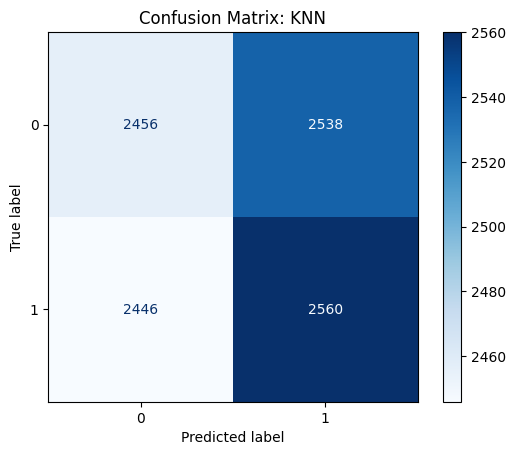

In [158]:
# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        "model": model,
        "accuracy": acc,
        "f1_score": f1
    }

    print(f"{name} Accuracy: {acc:.4f}")
    print(f"{name} F1-score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

In [72]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)
grid.fit(X_train, y_train)

print(f"Best Params: {grid.best_params_}")
print(f"Best F1 on CV: {grid.best_score_:.4f}")

best_rf = grid.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 on CV: 0.5227


In [74]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.0 MB/s eta 0:00:00


In [75]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=100, random_state=42)
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print("F1-score:", f1_score(y_test, y_pred_cat))

Learning rate set to 0.049775
0:	learn: 0.6930434	total: 74ms	remaining: 1m 13s
100:	learn: 0.6834382	total: 3.14s	remaining: 28s
200:	learn: 0.6747844	total: 8.06s	remaining: 32s
300:	learn: 0.6651696	total: 11.5s	remaining: 26.8s
400:	learn: 0.6553703	total: 15s	remaining: 22.3s
500:	learn: 0.6460987	total: 18.6s	remaining: 18.5s
600:	learn: 0.6374819	total: 23.4s	remaining: 15.6s
700:	learn: 0.6291296	total: 26.7s	remaining: 11.4s
800:	learn: 0.6215006	total: 31s	remaining: 7.69s
900:	learn: 0.6138354	total: 36.8s	remaining: 4.05s
999:	learn: 0.6064720	total: 38.3s	remaining: 0us
Accuracy: 0.4982
F1-score: 0.5047374654559811


In [76]:
cat_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Temperature (°C),8.983592
1,Upload Speed (Mbps),8.831426
2,Download Speed (Mbps),8.462099
3,Jitter (ms),8.438848
4,Ping to Google (ms),8.270799
5,Data Usage (MB),8.245403
6,Signal Strength (dBm),8.231624
7,Latency (ms),7.706153
8,Battery Level (%),7.301216
9,Connected Duration (min),6.717912
